In [1]:
%config Completer.use_jedi = False

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from scipy.interpolate import LinearNDInterpolator
import numpy as np
import cartopy.crs as ccrs
import cartopy
from mpl_toolkits.axes_grid1 import make_axes_locatable
import xarray as xr
import matplotlib.animation as animation
from IPython import display
import tqdm
import metpy.calc as mpcalc
import pyproj as proj
from regrid import regrid
from metpy.cbook import get_test_data
from metpy.interpolate import cross_section
from cartoplot import cartoplot
import metpy
from metpy.units import units
import pickle
from netCDF4 import Dataset
from ll_xy import lonlat_to_xy
import numpy as np
import datetime
import mask
from calendar import monthrange

/home/robbie/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/robbie/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


# Get generic data

In [3]:
e0 = datetime.date(1900,1,1)

with Dataset('/media/robbie/Brokendrive/E5/ERA_nh_1973_12.nc') as ERA5_data:
    lons = np.array(ERA5_data['longitude'])
    lats = np.array(ERA5_data['latitude'])
    
ERA5_lon_grid = np.array([np.array(lons), ] * 121)

ERA5_lat_grid = np.array([np.array(lats), ] * 1440).T

ERA_x_grid, ERA_y_grid = lonlat_to_xy(ERA5_lon_grid, ERA5_lat_grid,hemisphere='n')

dx, dy = mpcalc.lat_lon_grid_deltas(ERA5_lon_grid, ERA5_lat_grid)

cos_lons, sin_lons = np.cos(np.deg2rad(ERA5_lon_grid)), np.sin(np.deg2rad(ERA5_lon_grid))

points = np.column_stack((ERA_x_grid.ravel(),ERA_y_grid.ravel()))

tri = Delaunay(points)  # Compute the triangulation

# Get metpy grid vars for ease grid

In [4]:
ease_lons, ease_lats = mask.get('lon'), mask.get('lat')

ease_dx, ease_dy = mpcalc.lat_lon_grid_deltas(ease_lons, ease_lats)

crs_wgs = proj.Proj(init='epsg:4326')  # assuming you're using WGS84 geographic
args = proj.Proj(proj="aeqd", lat_0=90, lon_0=0, datum="WGS84", units="m")

xout, yout = proj.transform(crs_wgs, args, np.array(ease_lons),np.array(ease_lats))

ease_dx = abs(ease_dx); ease_dy = abs(ease_dy)

ease_cos_lons, ease_sin_lons = np.cos(np.deg2rad(ease_lons)), np.sin(np.deg2rad(ease_lons))

/home/robbie/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/robbie/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-

# Process annual ERA5 files

In [6]:
data_dir = '/media/robbie/TOSHIBA EXT/vorticity_files/'

years = tqdm.trange(1989,2022)

for year in [2021]:
    
    print(year)
    with Dataset(f'/media/robbie/TOSHIBA EXT/E5/{year}.nc') as ERA5_data:
        
        good_months = range(1,13) if year != 2021 else [1,2]
        
        d=0
        for month in good_months:
                        
            days_in_month = monthrange(year,month)[1]            
            
#             if year != 2020:
                
            v10 = np.array(ERA5_data['v10'][d*8:(d+days_in_month)*8])
            u10 = np.array(ERA5_data['u10'][d*8:(d+days_in_month)*8])
            msl = np.array(ERA5_data['msl'][d*8:(d+days_in_month)*8])

#             elif (year == 2020) & (month < 12):

#                 v10 = np.array(ERA5_data['v10'][d*8:(d+days_in_month)*8,0])
#                 u10 = np.array(ERA5_data['u10'][d*8:(d+days_in_month)*8,0])
#                 msl = np.array(ERA5_data['msl'][d*8:(d+days_in_month)*8,0])
                
#             else:            
    
#                 v10 = np.array(ERA5_data['v10'][d*8:(d+days_in_month)*8,1])
#                 u10 = np.array(ERA5_data['u10'][d*8:(d+days_in_month)*8,1])
#                 msl = np.array(ERA5_data['msl'][d*8:(d+days_in_month)*8,1])

            
            t = np.array(ERA5_data['time'][d*8:(d+days_in_month)*8])

            d += days_in_month       

            dates = [e0 + datetime.timedelta(hours=int(h)) for h in t]
            
            ####### Regrid msl to EASE grid #######

            ease_msl = np.full((v10.shape[0], ease_lons.shape[0], ease_lons.shape[1]),np.nan)
            ease_u10 = np.full((v10.shape[0], ease_lons.shape[0], ease_lons.shape[1]),np.nan)
            ease_v10 = np.full((v10.shape[0], ease_lons.shape[0], ease_lons.shape[1]),np.nan)
            
            for i in range(ease_u10.shape[0]):
#             for i in range(3):
                
                interpolator = LinearNDInterpolator(tri, msl[i].ravel())
                ease_msl[i] = interpolator((xout,yout))

                interpolator = LinearNDInterpolator(tri, u10[i].ravel())
                ease_u10[i] = interpolator((xout,yout))

                interpolator = LinearNDInterpolator(tri, v10[i].ravel())
                ease_v10[i] = interpolator((xout,yout))

            x10 = np.multiply(ease_u10,ease_cos_lons) - np.multiply(ease_v10,ease_sin_lons)
            y10 = np.multiply(ease_u10,ease_sin_lons) + np.multiply(ease_v10,ease_cos_lons)

            x10 = x10* units.meter / units.second
            y10 = y10* units.meter / units.second

            vort_3d_array = np.full(x10.shape, np.nan)
            lapl_3d_array = np.full(x10.shape, np.nan)
            div_3d_array  = np.full(x10.shape, np.nan)
            vort_monthlies = np.full((12,x10.shape[1],x10.shape[2]), np.nan)

            for i in range(x10.shape[0]):
#             for i in range(3):

                vort = np.array(mpcalc.vorticity(x10[i], y10[i], dx= ease_dx,dy= ease_dy))*1e6
    
                div = np.array(mpcalc.divergence(x10[i], y10[i], dx= ease_dx,dy= ease_dy))*1e6
        
                lapl = mpcalc.laplacian(ease_msl[i]*1e5,deltas=(ease_dy,ease_dx))
                
                vort_3d_array[i] = vort
                div_3d_array[i] = div
                lapl_3d_array[i] = lapl*1e5

            vort_mon_ave = np.nanmean(vort_3d_array,axis=0)
            div_mon_ave = np.nanmean(div_3d_array,axis=0)
            
            data_vars = {'vort_3hr':(['hrs','x','y'],vort_3d_array.astype(np.float32)),
                                        'lapl_3hr':(['hrs','x','y'],lapl_3d_array.astype(np.float32)),
                                        'div_3hr' :(['hrs','x','y'], div_3d_array.astype(np.float32)),
                                        'div_ave' :(['x','y'],div_mon_ave.astype(np.float32)),
                                        'vort_ave':(['x','y'],vort_mon_ave.astype(np.float32))}
            
            ds = xr.Dataset(data_vars=data_vars,
                            coords={'lon':(['x','y'],ease_lons),
                                        'lat':(['x','y'],ease_lats),
                                        'hrs_since_1900':(['hrs'],t)})

            ds.to_netcdf(f'{data_dir}{year}{str(month).zfill(2)}.nc')


  0%|          | 0/33 [00:00<?, ?it/s]

2021


/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: Mean of empty slice
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: Mean of empty slice


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): hrs(248), x(361), y(361)
    variables(dimensions): float32 vort_3hr(hrs,x,y), float32 lapl_3hr(hrs,x,y), float32 div_3hr(hrs,x,y), float32 div_ave(x,y), float32 vort_ave(x,y), float32 lon(x,y), float32 lat(x,y), int32 hrs_since_1900(hrs)
    groups: 



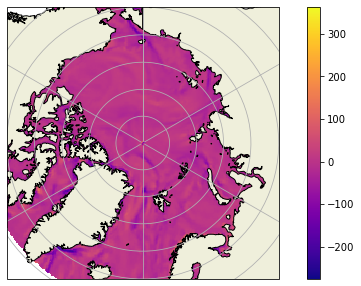

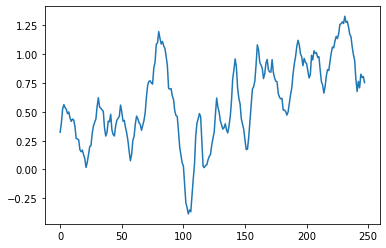

In [11]:
with Dataset('/home/robbie/Dropbox/beaufort_sea/vorticity_files/202101.nc') as d:
    print(d)
    
    v = np.array(d['div_3hr'])
    cartoplot(ease_lons,ease_lats,v[0])
#     t = np.array(d['hrs'])
    
    t0 = datetime.datetime(1900,1,1)

#     real_times = [t0 + datetime.timedelta(hours=int(s)) for s in t]
    
    mv = np.nanmean(v, axis=(1,2))
    
    plt.plot(mv)

In [ ]:
with Dataset('/media/robbie/TOSHIBA EXT/E5/2021.nc') as d:
    
    print(d)
    
    v = np.array(d['v10'])
    
    t = np.array(d['time'])
    
    
    t0 = datetime.datetime(1900,1,1)

    real_times = [t0 + datetime.timedelta(hours=int(s)) for s in t]
    
    mv = np.nanmean(v, axis=(1,2))
    

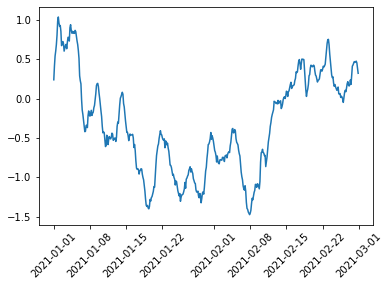

In [17]:
plt.plot(real_times,mv)
    
plt.tick_params('x',rotation=45)    

# Legacy code below - do not use!

In [32]:
data_dir = '/home/robbie/Dropbox/beaufort_sea/vorticity_files/'

for year in range(1975,1992):
    
    print(year)

    for month in tqdm.trange(1,13):

        with Dataset(f'/media/robbie/Brokendrive/E5/ERA_nh_{year}_{str(month).zfill(2)}.nc') as ERA5_data:

            
            v10 = np.array(ERA5_data['v10'])
            u10 = np.array(ERA5_data['u10'])
            
            t = np.array(ERA5_data['time'])

            d += days_in_month       

            dates = [e0 + datetime.timedelta(hours=int(h)) for h in t]
            
            ####### Regrid msl to EASE grid #######

#             ease_msl = np.zeros((v10.shape[0], ease_lons.shape[0], ease_lons.shape[1]))
            ease_u10 = np.zeros((v10.shape[0], ease_lons.shape[0], ease_lons.shape[1]))
            ease_v10 = np.zeros((v10.shape[0], ease_lons.shape[0], ease_lons.shape[1]))
            
            for i in range(ease_u10.shape[0]):
                
#                 interpolator = LinearNDInterpolator(tri, msl[i].ravel())
#                 ease_msl[i] = interpolator((xout,yout))

                interpolator = LinearNDInterpolator(tri, u10[i].ravel())
                ease_u10[i] = interpolator((xout,yout))

                interpolator = LinearNDInterpolator(tri, v10[i].ravel())
                ease_v10[i] = interpolator((xout,yout))

            x10 = np.multiply(ease_u10,ease_cos_lons) - np.multiply(ease_v10,ease_sin_lons)
            y10 = np.multiply(ease_u10,ease_sin_lons) + np.multiply(ease_v10,ease_cos_lons)

            x10 = x10* units.meter / units.second
            y10 = y10* units.meter / units.second

            vort_3d_array = np.zeros(x10.shape)
#             lapl_3d_array = np.zeros(x10.shape)
            vort_monthlies = np.zeros((12,x10.shape[1],x10.shape[2]))

            for i in range(x10.shape[0]):

                vort = np.array(mpcalc.vorticity(x10[i], y10[i], dx= ease_dx,dy= ease_dy))*1e6
#                 lapl = mpcalc.laplacian(ease_msl[i]*1e5,deltas=(ease_dy,ease_dx))
                
                vort_3d_array[i] = vort
#                 lapl_3d_array[i] = lapl*1e5

            vort_mon_ave = np.nanmean(vort_3d_array,axis=0)

            ds = xr.Dataset( data_vars={'vort_3hr':(['hrs','x','y'],vort_3d_array.astype(np.float32)),
#                                         'lapl_3hr':(['hrs','x','y'],lapl_3d_array.astype(np.float32)),
                                        'vort_ave':(['x','y'],vort_mon_ave.astype(np.float32))},

                             coords =  {'lon':(['x','y'],ease_lons),
                                        'lat':(['x','y'],ease_lats),
                                        'hrs_since_1900':(['hrs'],t)})

            ds.to_netcdf(f'{data_dir}{year}{str(month).zfill(2)}.nc')

  0%|          | 0/12 [00:00<?, ?it/s]

1975


/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice
  0%|          | 0/12 [00:00<?, ?it/s]

1976


  0%|          | 0/12 [00:00<?, ?it/s]

1977


  0%|          | 0/12 [00:00<?, ?it/s]

1978


  0%|          | 0/12 [00:00<?, ?it/s]

1979


  0%|          | 0/12 [00:00<?, ?it/s]

1980


  0%|          | 0/12 [00:00<?, ?it/s]

1981


  0%|          | 0/12 [00:00<?, ?it/s]

1982


  0%|          | 0/12 [00:00<?, ?it/s]

1983


  0%|          | 0/12 [00:00<?, ?it/s]

1984


  0%|          | 0/12 [00:00<?, ?it/s]

1985


  0%|          | 0/12 [00:00<?, ?it/s]

1986


  0%|          | 0/12 [00:00<?, ?it/s]

1987


  0%|          | 0/12 [00:00<?, ?it/s]

1988


  0%|          | 0/12 [00:00<?, ?it/s]

1989


  0%|          | 0/12 [00:00<?, ?it/s]

1990


  0%|          | 0/12 [00:00<?, ?it/s]

1991


100%|██████████| 12/12 [04:35<00:00, 22.92s/it]
